In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 642.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 5.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import xml.etree.ElementTree as ET
import shutil
import tensorflow as tf
from sklearn.model_selection import *
from ultralytics import YOLO
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=secret_value_0)

2024-04-22 04:43:39.760382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 04:43:39.760480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 04:43:40.036604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.ne

True

In [3]:
train_path = '/kaggle/input/tdl-dataset-22-04/train/'
test_path = '/kaggle/input/tdl-dataset-22-04/test/'
classes = ['Signature','Stamp' ,'Others']

In [4]:
def preprocess_XML(filename):
    tree=ET.parse(filename)
    root=tree.getroot()
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)
    bounding_boxes=[]
    for object_tree in root.findall('object'):
        for bounding_box in object_tree.iter('bndbox'):
            xmin = (float(bounding_box.find('xmin').text))
            ymin = (float(bounding_box.find('ymin').text))
            xmax = (float(bounding_box.find('xmax').text))
            ymax = (float(bounding_box.find('ymax').text))
        class_name = object_tree.find('name').text
        class_dict={classes[i]:i for i in range(len(classes))}
        if width == 0 : width =+700
        if height == 0 : height =+700
        bounding_box = [
          class_dict[class_name],(xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
        (ymax-ymin)/height]
        bounding_boxes.append(bounding_box)
    return tf.convert_to_tensor(bounding_boxes)

In [5]:
train_dir = sorted(os.listdir(train_path))
images_name = []
xml_name = []
for path in train_dir:
    if path.split('.')[-1] == 'jpg':images_name.append(path)
    else:xml_name.append(path)

In [6]:
images_name

['001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg',
 '010.jpg',
 '011.jpg',
 '012.jpg',
 '013.jpg',
 '014.jpg',
 '015.jpg',
 '016.jpg',
 '017.jpg',
 '018.jpg',
 '019.jpg',
 '020.jpg',
 '021.jpg',
 '022.jpg',
 '023.jpg',
 '024.jpg',
 '025.jpg',
 '026.jpg',
 '027.jpg',
 '028.jpg',
 '029.jpg',
 '030.jpg',
 '031.jpg',
 '032.jpg',
 '033.jpg',
 '034.jpg',
 '035.jpg',
 '036.jpg',
 '037.jpg',
 '038.jpg',
 '039.jpg',
 '040.jpg',
 '041.jpg',
 '042.jpg',
 '043.jpg',
 '044.jpg',
 '045.jpg',
 '046.jpg',
 '047.jpg',
 '048.jpg',
 '049.jpg',
 '050.jpg',
 '051.jpg',
 '052.jpg',
 '053.jpg',
 '054.jpg',
 '055.jpg',
 '056.jpg',
 '057.jpg',
 '058.jpg',
 '059.jpg',
 '060.jpg',
 '061.jpg',
 '062.jpg']

In [7]:
train_images_name , val_images_name , train_xml_name , val_xml_name = train_test_split(images_name , xml_name ,
                                                                                test_size = 0.2,random_state = 42)

In [8]:
train_images , train_xml ,val_images , val_xml = [],[],[],[]
bbox_visualize=[]
for tr_i in range(len(train_images_name)):
    print(train_path + train_images_name[tr_i])
    img = cv2.imread(train_path + train_images_name[tr_i],1)
    img=cv2.resize(img,(128,128))
    train_images.append(img)
    bbox = preprocess_XML(train_path + train_xml_name[tr_i])
    train_xml.append(bbox)

/kaggle/input/tdl-dataset-22-04/train/014.jpg
/kaggle/input/tdl-dataset-22-04/train/034.jpg
/kaggle/input/tdl-dataset-22-04/train/035.jpg
/kaggle/input/tdl-dataset-22-04/train/004.jpg
/kaggle/input/tdl-dataset-22-04/train/018.jpg
/kaggle/input/tdl-dataset-22-04/train/055.jpg
/kaggle/input/tdl-dataset-22-04/train/009.jpg
/kaggle/input/tdl-dataset-22-04/train/007.jpg
/kaggle/input/tdl-dataset-22-04/train/032.jpg
/kaggle/input/tdl-dataset-22-04/train/005.jpg
/kaggle/input/tdl-dataset-22-04/train/046.jpg
/kaggle/input/tdl-dataset-22-04/train/020.jpg
/kaggle/input/tdl-dataset-22-04/train/053.jpg
/kaggle/input/tdl-dataset-22-04/train/037.jpg
/kaggle/input/tdl-dataset-22-04/train/054.jpg
/kaggle/input/tdl-dataset-22-04/train/042.jpg
/kaggle/input/tdl-dataset-22-04/train/059.jpg
/kaggle/input/tdl-dataset-22-04/train/016.jpg
/kaggle/input/tdl-dataset-22-04/train/041.jpg
/kaggle/input/tdl-dataset-22-04/train/028.jpg
/kaggle/input/tdl-dataset-22-04/train/027.jpg
/kaggle/input/tdl-dataset-22-04/tr

In [9]:
for vl_i in range(len(val_images_name)):
    img = cv2.imread(train_path + val_images_name[vl_i],1)
    img = cv2.resize(img,(128,128))
    val_images.append(img)
    bbox = preprocess_XML(train_path + val_xml_name[vl_i])
    val_xml.append(bbox)

In [10]:
train_xml[0][0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([          0,     0.78125,     0.64531,       0.175,        0.05], dtype=float32)>

/tmp/ipykernel_27/973128048.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,5,i+1)


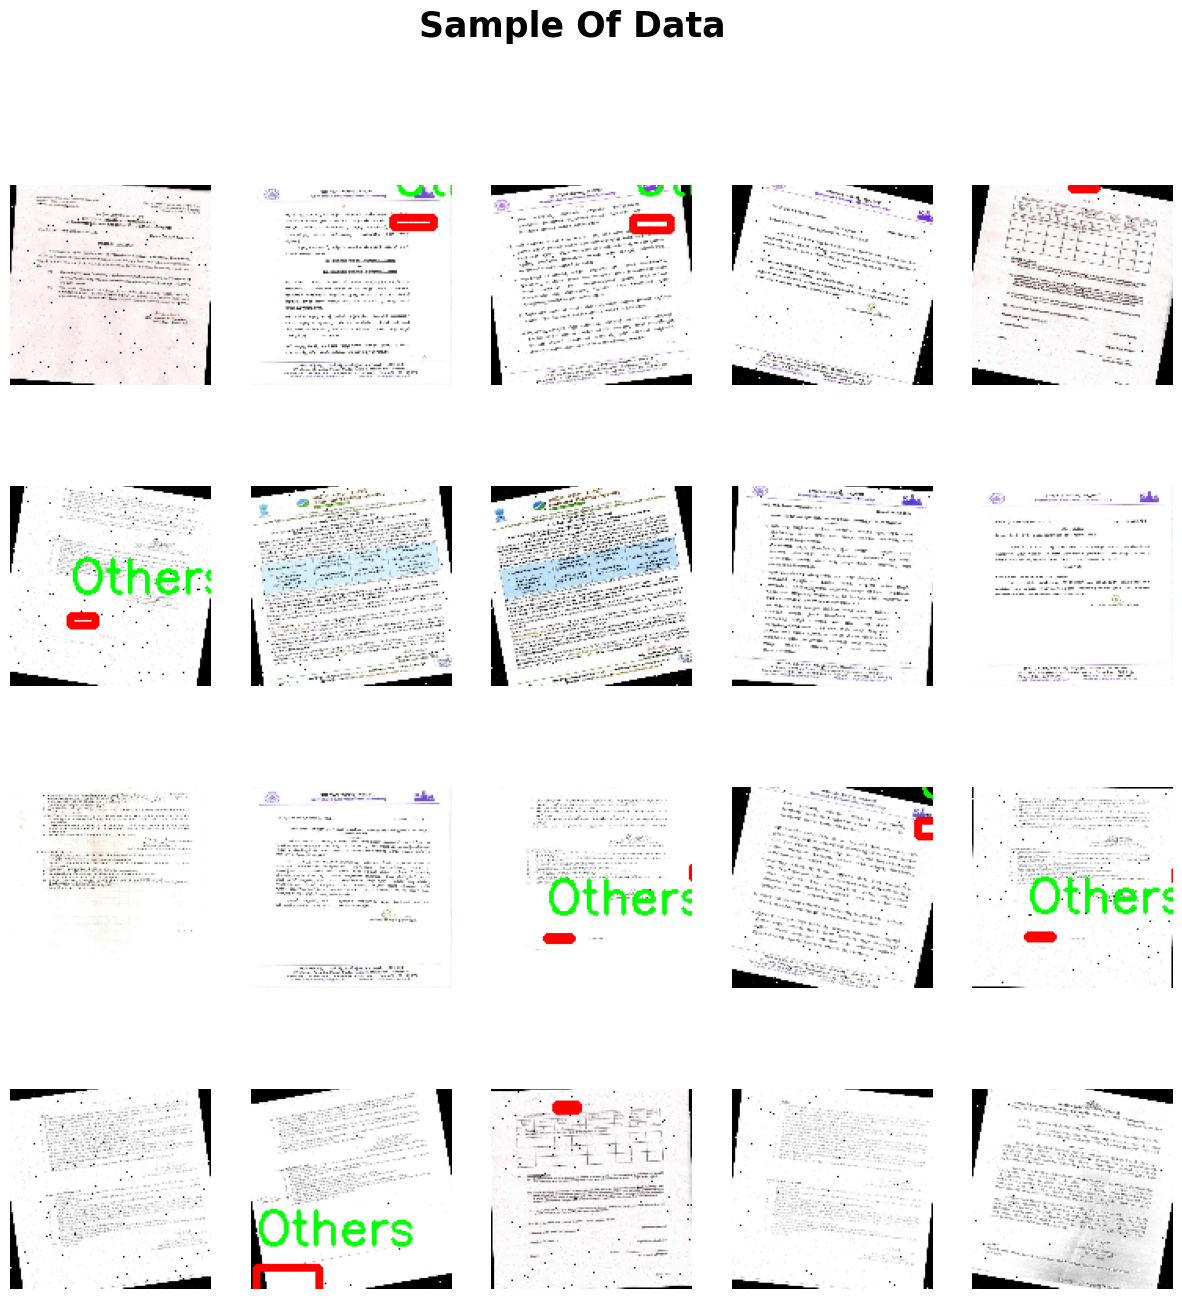

In [11]:
fig,axs = plt.subplots(figsize = (15,15))
fig.suptitle('Sample Of Data',fontweight = 'bold' , fontsize = 25 ,ha = 'center')
for i in range(20):
  plt.subplot(4,5,i+1)
  for j in range(len(train_xml[i])):
        w = int(train_xml[i][j][3]*224)
        h = int(train_xml[i][j][4]*224)
        xc = int(train_xml[i][j][1]*224)
        yc = int(train_xml[i][j][2]*224)
        xmin = xc - (w//2)
        ymin = yc - (h//2)
        xmax = xc + (w//2)
        ymax = yc + (h//2)
        cv2.rectangle(train_images[i],(xmin,ymin),
        (xmax,ymax),(255,0,0),3)
        cv2.putText(train_images[i], classes[int(train_xml[i][j][0])], (int(xmin), int(ymin - 15)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        plt.imshow(train_images[i]/255)
        plt.axis('off') 

In [12]:
train_images_name[0]

'014.jpg'

In [13]:
train_txt , val_txt = [] ,[]

for n in train_images_name:
    name = n.split('.')[0]+'.txt'
    train_txt.append(name)

for n in val_images_name:
    name = n.split('.')[0]+'.txt'
    val_txt.append(name)

In [14]:
train_txt[0]

'014.txt'

In [15]:
for idx,arry in enumerate(train_xml):
    if idx==0:
        for arr in arry:
            print(" ".join(arr.numpy().flatten().astype(str)))

0.0 0.78125 0.6453125 0.175 0.05


In [16]:
len(train_xml)

49

In [17]:
for idx,arry in enumerate(train_xml):
    with open(train_txt[idx], "w") as file:
        for arr in arry:
            arr_np=arr.numpy()
            arr_flattened=arr_np.flatten()
            arr_str=arr_flattened.astype(str)
            line=" ".join(arr_str)+"\n"
            file.write(line)

In [18]:
for idx,arry in enumerate(val_xml):
    with open(val_txt[idx], "w") as file:
        for arr in arry:
            arr_np=arr.numpy()
            arr_flattened=arr_np.flatten()
            arr_str=arr_flattened.astype(str)
            line=" ".join(arr_str)+"\n"
            file.write(line)

In [19]:
dir_path="/kaggle/working/data"
dir_train_path="/kaggle/working/data/train"
dir_val_path="/kaggle/working/data/val"
dir_train_images_path = '/kaggle/working/data/train/images'
dir_val_images_path = '/kaggle/working/data/val/images'
dir_train_labels_path = '/kaggle/working/data/train/labels'
dir_val_labels_path = '/kaggle/working/data/val/labels'

In [20]:
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    os.makedirs(dir_train_path)
    os.makedirs(dir_val_path)
    os.makedirs(dir_train_images_path)
    os.makedirs(dir_train_labels_path)
    os.makedirs(dir_val_images_path)
    os.makedirs(dir_val_labels_path)

In [21]:
train_path

'/kaggle/input/tdl-dataset-22-04/train/'

In [22]:
dir_train_images_path

'/kaggle/working/data/train/images'

In [23]:
for f1,f2 in zip(train_images_name,train_txt):
    if f1.endswith((".jpg", ".jpeg", ".png", ".gif")):
        source_file1=os.path.join(train_path,f1)
        source_file2=os.path.join("/kaggle/working",f2)
        destination_file1=os.path.join(dir_train_images_path,f1)
        destination_file2=os.path.join(dir_train_labels_path,f2)
        shutil.copy2(source_file1, destination_file1)
        shutil.copy2(source_file2, destination_file2)

In [24]:
for f1 , f2 in zip(val_images_name,val_txt):
    # Check if the file is an image (you can customize this check)
    if f1.endswith((".jpg", ".jpeg", ".png", ".gif")):
        source_file1 = os.path.join(train_path, f1)
        source_file2 = os.path.join('/kaggle/working', f2)
        destination_file1 = os.path.join(dir_val_images_path, f1)
        destination_file2 = os.path.join(dir_val_labels_path, f2)

        # Copy the image file to the new directory
        shutil.copy2(source_file1, destination_file1)
        shutil.copy2(source_file2, destination_file2)

In [25]:
with open("/kaggle/working/data.yaml", "w") as file:
    file.write("train: /kaggle/working/data/train\n")
    file.write("val: /kaggle/working/data/val\n")
    file.write("\n")
    file.write("nc: 3\n")
    file.write("names: ['Signature','Stamp' ,'Others']\n")

In [26]:
for file in os.listdir("/kaggle/working/"):
    if file.endswith(".txt"):
        pass
    else:
        print(file)

__notebook__.ipynb
data
data.yaml


In [27]:
model = YOLO('yolov5nu.pt')
model.train(data = '/kaggle/working/data.yaml',epochs = 100 , imgsz = 128)

100%|██████████| 5.27M/5.27M [00:00<00:00, 63.9MB/s]


Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-04-22 04:44:14,814	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-22 04:44:15,754	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

wandb: Currently logged in as: acram (ramrocks). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240422_044417-ui73j2n1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/ramrocks/YOLOv8
wandb: 🚀 View run at https://wandb.ai/ramrocks/YOLOv8/runs/ui73j2n1


Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 71.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train/labels... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<00:00, 1131.61it/s]

train: New cache created: /kaggle/working/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/val/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1418.54it/s]

val: New cache created: /kaggle/working/data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.608G      2.878       3.73      1.215          1        128: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.451G      2.848      4.037      1.305          5        128: 100%|██████████| 4/4 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.428G       3.76      4.555      1.797          4        128: 100%|██████████| 4/4 [00:00<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.451G      2.837      3.829      1.233          0        128: 100%|██████████| 4/4 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.459G      2.808      4.484      1.384          4        128: 100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.75it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.459G      2.102      3.315      1.037          0        128: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.459G      2.698      3.598       1.14          1        128: 100%|██████████| 4/4 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.459G      2.313      3.294      1.014          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

                   all         13         16          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.459G      2.684      3.192      1.091          4        128: 100%|██████████| 4/4 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]

                   all         13         16   0.000403      0.167    0.00121   0.000121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.459G      2.705      3.323      1.142          1        128: 100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]

                   all         13         16   0.000763     0.0667    0.00164   0.000214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.459G      2.869      3.232      1.275          4        128: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

                   all         13         16    0.00188      0.433    0.00859    0.00221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.459G      2.289      2.361      1.109          4        128: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]

                   all         13         16    0.00277        0.5     0.0437     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.459G      2.504      2.519      1.232          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

                   all         13         16    0.00339      0.533      0.229     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.459G      2.036          2      1.078          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]

                   all         13         16    0.00363      0.567       0.16     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.459G      2.551      2.306      1.103          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

                   all         13         16    0.00392      0.583     0.0788     0.0247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.459G      2.777       2.31      1.516          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]

                   all         13         16    0.00347        0.5       0.13     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.459G      2.439      2.314      1.137          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

                   all         13         16    0.00332      0.467      0.159     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.459G      2.756      2.542      1.072          4        128: 100%|██████████| 4/4 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

                   all         13         16    0.00434      0.467      0.112     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.459G      2.603      1.981      1.208          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]

                   all         13         16    0.00573        0.5      0.108     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.459G      3.059      2.723      1.265          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]

                   all         13         16          1     0.0659      0.126     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.459G      2.961      2.455      1.304          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

                   all         13         16      0.866     0.0667      0.347      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.459G      2.802      2.222      1.183          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

                   all         13         16      0.804        0.1      0.282      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.438G       2.42      2.308      1.185          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]

                   all         13         16      0.764      0.267      0.374      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.438G      2.683      2.118      1.204          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]

                   all         13         16      0.868      0.371      0.466       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.438G      2.847      2.418      1.259          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

                   all         13         16      0.868      0.167      0.489      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.438G      2.794      2.107      1.248          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]

                   all         13         16      0.833      0.415      0.476      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.438G      1.866      1.706     0.9645          0        128: 100%|██████████| 4/4 [00:00<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


                   all         13         16      0.877      0.293      0.359      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.438G      2.718      2.213      1.073          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

                   all         13         16      0.902        0.3       0.39      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.438G      2.346      1.725       1.13          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         13         16      0.896      0.455       0.49      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.438G      2.509      2.378      1.213          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


                   all         13         16      0.939       0.46      0.487      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.438G      2.081      1.713     0.9913          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


                   all         13         16      0.935      0.467      0.494      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.438G      3.014      2.143      1.154          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

                   all         13         16      0.942      0.467      0.479      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.438G      2.606      1.846      1.136          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]

                   all         13         16      0.901      0.467      0.485      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.438G      2.285       1.79      1.183          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

                   all         13         16      0.923      0.495      0.503      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.438G      2.618      2.213      1.293          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]

                   all         13         16      0.914      0.493      0.505      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.438G      2.278      2.112      1.115          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

                   all         13         16      0.919      0.496      0.522      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.438G      2.481      1.655      1.032          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

                   all         13         16      0.992      0.499      0.524      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.438G      1.991      1.829     0.9685          0        128: 100%|██████████| 4/4 [00:00<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         13         16      0.987        0.5      0.514      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.438G      2.139       1.76     0.9277          0        128: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

                   all         13         16      0.982        0.5      0.511      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.438G      2.415      1.615       1.05          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

                   all         13         16      0.909      0.499      0.497      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.438G      2.446      1.811      1.081          5        128: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]

                   all         13         16      0.922      0.526      0.543      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.438G      2.434        1.8      1.078          6        128: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all         13         16       0.99      0.441      0.531      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.438G      2.621      1.883      1.088          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

                   all         13         16      0.526        0.5      0.534       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.438G      1.722      1.361     0.9046          0        128: 100%|██████████| 4/4 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

                   all         13         16      0.542      0.488      0.538      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.438G      2.768      1.669      1.253          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]

                   all         13         16      0.491      0.496      0.524      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.438G      2.645      1.597      1.178          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

                   all         13         16      0.964      0.433      0.531      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.438G      1.891      1.441     0.8434          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

                   all         13         16      0.512      0.521      0.545      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.438G      2.225      1.663      1.001          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

                   all         13         16      0.483        0.5      0.398      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.438G      2.536      1.722      1.223          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]

                   all         13         16      0.782      0.467      0.361      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.438G      2.374       1.61       1.29          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all         13         16      0.829      0.488      0.369      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.438G      2.712       1.95       1.15          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]

                   all         13         16      0.745      0.467       0.32      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.438G      2.296      1.636      1.156          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

                   all         13         16      0.759      0.467      0.433      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.438G      1.632      1.401     0.8363          0        128: 100%|██████████| 4/4 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

                   all         13         16      0.811      0.486      0.458      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.438G      2.133      1.708       1.08          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]

                   all         13         16      0.466      0.477      0.445      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.438G      2.257       1.75      1.087          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]

                   all         13         16      0.432      0.436      0.461      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.438G      2.394       1.68      1.058          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

                   all         13         16      0.467      0.533      0.504      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.438G      2.277      1.638      1.068          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]

                   all         13         16      0.431      0.523       0.48      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.438G      2.226      1.718     0.9528          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

                   all         13         16      0.434      0.133      0.437      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.438G      2.548      2.048      1.081          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]

                   all         13         16      0.458      0.133      0.421        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.438G       1.74      1.374     0.8053          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

                   all         13         16      0.457      0.397      0.426      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.438G      1.564      1.273     0.8595          0        128: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

                   all         13         16      0.822      0.464      0.443      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.438G      2.316      1.587      1.082          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]

                   all         13         16      0.935      0.462      0.494      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.438G      2.059      1.449      1.086          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


                   all         13         16      0.917      0.495      0.512       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.438G      2.399      1.901      1.129          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

                   all         13         16      0.832        0.5      0.476      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.438G       2.27      1.523     0.9796          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


                   all         13         16      0.903        0.5      0.483      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.438G      2.188      1.848     0.8946          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]

                   all         13         16      0.935        0.5      0.482      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.438G      2.396      1.708      1.187          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

                   all         13         16      0.799        0.5      0.481      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.438G       1.93      1.331      1.025          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]

                   all         13         16      0.696        0.5      0.412      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.438G      2.538      2.089      1.081          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.06it/s]

                   all         13         16      0.849      0.467      0.459      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.438G      2.185      1.785       1.05          3        128: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.75it/s]

                   all         13         16      0.929        0.5      0.483      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.438G      2.056      1.336      1.056          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

                   all         13         16      0.909        0.5      0.484      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.438G      2.561      1.652      1.109          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

                   all         13         16      0.874      0.492      0.492      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.438G      2.206      1.589      1.075          6        128: 100%|██████████| 4/4 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]

                   all         13         16      0.929        0.5       0.53      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.438G      1.776      1.706      1.077          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]

                   all         13         16      0.919      0.494      0.528      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.438G       1.53      1.267      0.813          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         13         16      0.963      0.467      0.505      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.438G      2.021      1.305      1.104          2        128: 100%|██████████| 4/4 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]

                   all         13         16        0.9      0.466      0.488      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.438G      2.016      1.612     0.9204          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]

                   all         13         16      0.879      0.458      0.471      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.438G      1.599      1.256     0.8023          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

                   all         13         16      0.849      0.427      0.453      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.438G      1.845      1.455     0.8343          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]

                   all         13         16      0.847      0.392      0.447      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.438G      2.109       1.62      1.106          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

                   all         13         16      0.856      0.352      0.454       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.438G      2.212      1.664      1.094          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]

                   all         13         16      0.831      0.167      0.454      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.438G      2.486      1.586       1.64          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]

                   all         13         16      0.823      0.394      0.464      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.438G      1.672      1.427     0.8239          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

                   all         13         16      0.837      0.439        0.5      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.438G      2.233      1.513      1.143          3        128: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

                   all         13         16      0.848      0.451        0.5      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.438G      1.771      1.373     0.8258          0        128: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

                   all         13         16      0.882      0.481      0.504      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.438G      2.465      1.677      1.024          4        128: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

                   all         13         16        0.9      0.497      0.514      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.438G      2.343      1.787     0.9799          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]

                   all         13         16      0.905        0.5      0.512      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.438G      1.486      1.049     0.7874          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

                   all         13         16      0.988      0.498      0.526      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.438G      2.328      1.384     0.9692          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]

                   all         13         16      0.978        0.5      0.535      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.438G      1.997      1.303      1.034          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]

                   all         13         16      0.974        0.5      0.543      0.297


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.438G      1.809      1.287      1.071          2        128: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]

                   all         13         16      0.975        0.5      0.543      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.459G      2.096      1.582      1.142          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

                   all         13         16      0.973        0.5      0.539       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.436G      2.181      1.517      1.068          2        128: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]

                   all         13         16      0.972        0.5      0.539      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.438G      1.432      1.539      0.811          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]

                   all         13         16      0.974        0.5       0.54      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.438G      1.794      1.279     0.9561          2        128: 100%|██████████| 4/4 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


                   all         13         16      0.976        0.5      0.539      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.438G      1.913      1.493      0.966          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]

                   all         13         16      0.975        0.5      0.537      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.438G      2.197      1.386      1.039          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

                   all         13         16      0.975        0.5      0.538      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.438G      2.229      1.566      1.184          1        128: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]

                   all         13         16      0.976        0.5      0.539      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.438G        2.1      1.599      1.031          1        128: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]

                   all         13         16      0.974        0.5      0.539       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.438G      1.786      1.291     0.8112          4        128: 100%|██████████| 4/4 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

                   all         13         16       0.97        0.5      0.542      0.389



100 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2503529 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


                   all         13         16      0.969        0.5      0.542      0.389
             Signature         13         10      0.977        0.5       0.55      0.273
                 Stamp         13          2      0.931          1      0.995      0.846
                Others         13          4          1          0     0.0824     0.0494
Speed: 0.0ms preprocess, 0.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▁▁▁▄▃▂▅▆▇▆▇▇█████▆▅▇▇▆▇▇▇▇▇█▇▇▇▇██████
wandb:     metrics/mAP50-95(B) ▁▁▁▁▁▂▂▁▄▅▅▄▄▆▅▆▆▅▅▃▃▄▅▅▄▅▅▅▆▆▅▅▆▇▆▆▇▇▇█
wandb:    metrics/precision(B) ▁▁▁▁▁▁▁▁▇▆▇▇█████▅█▇▆▄▄▄▇▇▇▇▇█▇▇▇▇▇█████
wandb:       metrics/recall(B) ▁▁▁▁▇██▇▂▅▆▅▇▇███▇▇▇▇▇█▃▇██▇▇▇▇▆▆▇██████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▃▄▅▄▅▅▆▄▅▅▃▄▄▃▄▂▅▄▅▃▄▄▁▄▄▄▄▂▃▂▄▃▄▄▃▁▃▂
wandb:          train/cls_loss ▆█▅▅▅▄▃▄▄▃▃▃▂▂▃▂▂▁▂▂▂▂▂▃▁▂▂▃▂▂▂▁▂▂▂▁▂▂▁▁
wandb:          train/dfl_loss ▄█▃▂▄▄▆▃▄▄▄▃▂▄▃▂▃▂▄▄▃▃▃▃▁▃▄▃▃▃▂▁▇▃▂▂▃▁▃▁
wandb:            val/box_loss █▆▅▅▄▃▄▃▃▃▂▃▃▃▂▂▂▃▂▄▅▃▂▄▄▃▃▃▃▂▃▃▂▂▂

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d66a89a9ae0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [28]:
metrics = model.val()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2503529 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /kaggle/working/data/val/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


                   all         13         16      0.969        0.5      0.542      0.372
             Signature         13         10      0.976        0.5      0.549      0.272
                 Stamp         13          2      0.932          1      0.995      0.796
                Others         13          4          1          0     0.0824     0.0494
Speed: 0.0ms preprocess, 11.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


In [29]:
results = model.predict(source = test_path , save = True , conf = 0.5, show = True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/16 /kaggle/input/tdl-dataset-22-04/test/063.jpg: 128x128 1 Signature, 1 Stamp, 7.4ms
image 2/16 /kaggle/input/tdl-dataset-22-04/test/064.jpg: 128x128 1 Signature, 1 Stamp, 7.2ms
image 3/16 /kaggle/input/tdl-dataset-22-04/test/065.jpg: 128x128 (no detections), 7.5ms
image 4/16 /kaggle/input/tdl-dataset-22-04/test/066.jpg: 128x128 1 Signature, 7.4ms
image 5/16 /kaggle/input/tdl-dataset-22-04/test/067.jpg: 128x128 (no detections), 7.2ms
image 6/16 /kaggle/input/tdl-dataset-22-04/test/068.jpg: 128x128 1 Stamp, 7.4ms
image 7/16 /kaggle/input/tdl-dataset-22-04/test/069.jpg: 128x128 1 Signature, 1 Stamp, 7.4ms
image 8/16 /kaggle/input/tdl-dataset-22-04/test/070.jpg: 128x128 1 Signature, 1 Stamp, 7.3ms
image 9/16 /kaggle/input/tdl-dataset-22-04/test/071.jpg: 128x128 1 Signature, 7.1ms
image 10/16 /kaggle/input/tdl-dataset-22-04/test/072.jpg: 128x128 1 Signature, 7.2ms
image 11/16 /kaggle/input/tdl-dataset-22-04/

In [30]:
# results

In [31]:
print(type(results))

<class 'list'>


In [32]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/data/val/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


                   all         13         16      0.969        0.5      0.542      0.372
             Signature         13         10      0.976        0.5      0.549      0.272
                 Stamp         13          2      0.932          1      0.995      0.796
                Others         13          4          1          0     0.0824     0.0494
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train4


array([    0.27192,     0.79571,    0.049439])

In [33]:
# print(test_path )

In [34]:
# model.val(data ='/kaggle/working/data.yaml')